In [ ]:
# 라이브러리 기본 참조
from hossam import *
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

# 클러스터링 관련 참조
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import ConvexHull
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

In [6]:
origin = hs_util.load_data("wholesale_customers")
df = origin.drop(["Channel", "Region"], axis=1)
df.head()

이 데이터 세트는 도매 유통업체의 고객 정보를 담고 있습니다. 다양한 제품 카테고리에 대한 연간 지출액(mu, 화폐 단위)을 포함합니다. (출처: https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set)

컬럼명            의미                  설명
----------------  --------------------  --------------------------------------------------------------------------------------------
Channel           유통 채널             고객의 거래 채널을 나타냄. 주로 Horeca(호텔·레스토랑·카페) 또는 Retail(소매점) 구분에 사용됨
Region            지역                  고객이 속한 지리적 지역 구분 변수. 특정 국가 내의 권역 정보
Fresh             신선식품 구매액       육류, 채소, 과일 등 신선식품 카테고리에 대한 연간 구매 금액
Milk              유제품 구매액         우유, 치즈, 요거트 등 유제품 카테고리에 대한 연간 구매 금액
Grocery           식료품 구매액         가공식품, 일반 식료품 등 장기 보관 식품 카테고리 구매 금액
Frozen            냉동식품 구매액       냉동 육류, 냉동 가공식품 등 냉동식품 카테고리 구매 금액
Detergents_Paper  세제·종이류 구매액    세제, 화장지, 키친타월 등 생활 소모품 구매 금액
Delicassen        즉석·가공식품 구매액  즉석식품, 델리 식품, 가공 반찬류 등의 구매 금액


✅ 테이블 정보
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 column

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


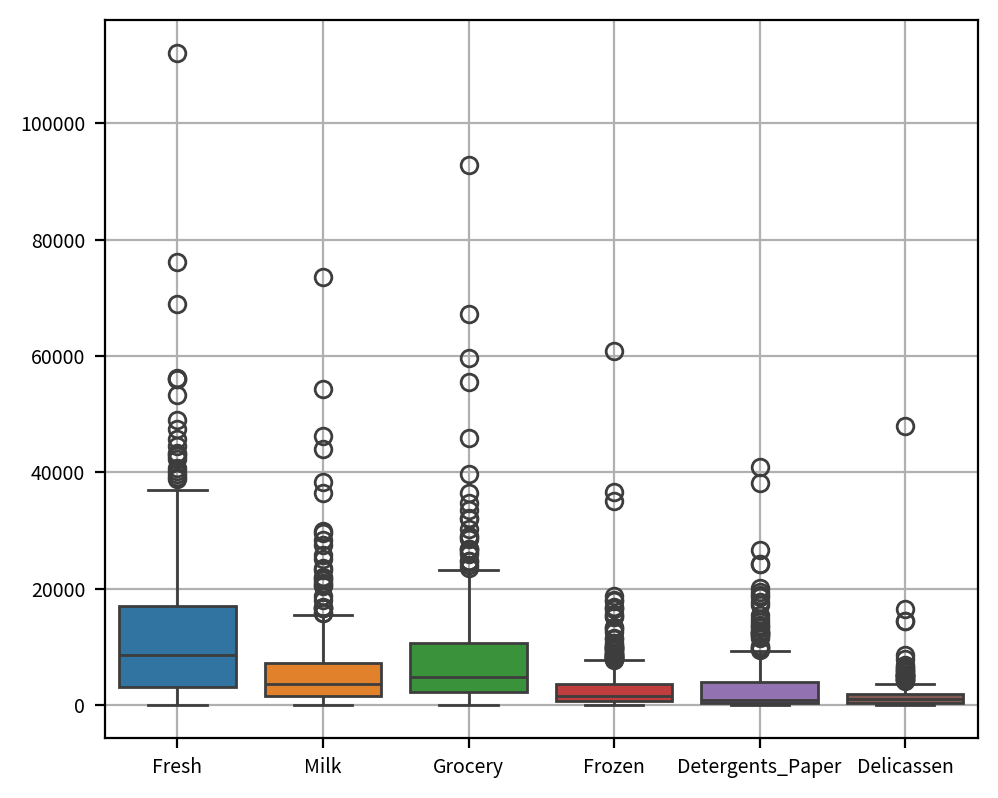

In [7]:
# 1) 그래프 초기화 (캔바스(fig)와 도화지(ax) 준비하기)
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df, orient="v", ax=ax)

# 3) 그래프 꾸미기
ax.grid(True)


plt.tight_layout()
plt.show()
plt.close()

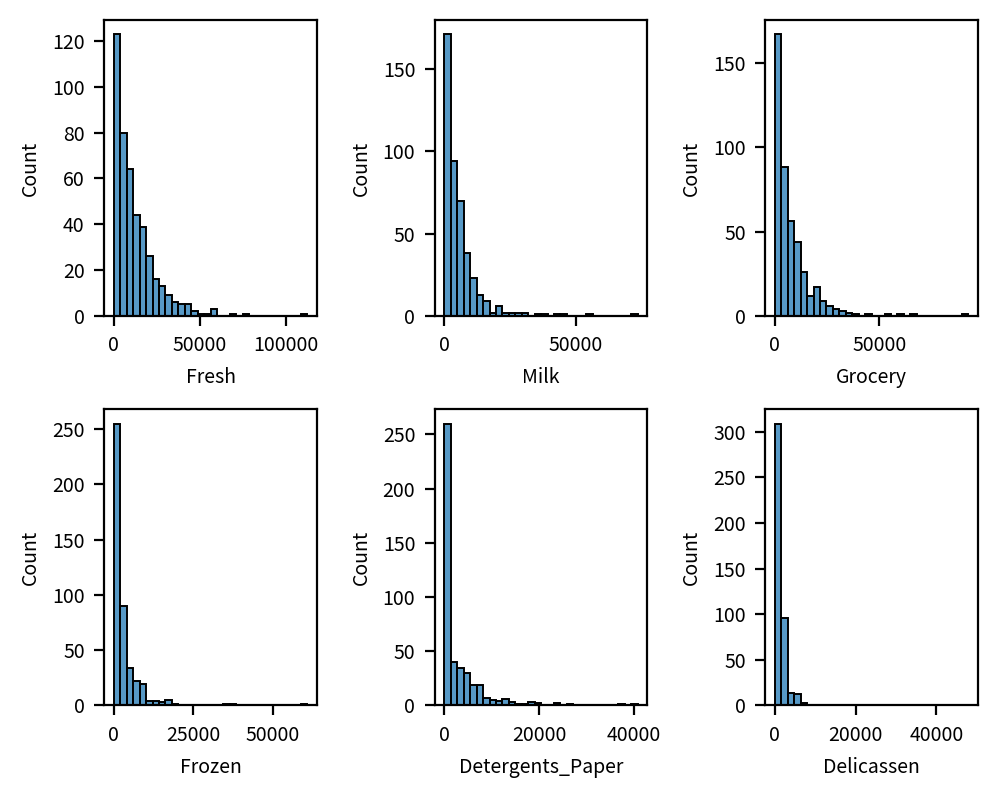

In [18]:
# 1) 그래프 초기화
width_px = 1000
height_px = 800
rows = 2
cols = 3
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(df.columns):
    r = i // cols
    c = i % cols
    sb.histplot(data=df, x=v, bins=30, edgecolor="#000000", linewidth=0.7, ax=ax[r, c])

plt.tight_layout()
plt.show()
plt.close()

In [20]:
from scipy.stats import zscore

In [22]:
# 이상치와 왜도 검정
data = df
results = {}

for col in data.columns:
    temp = data[col].dropna()
    # 왜도 계산
    skew_original = temp.skew()
    # Z-score 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))
    # 로그 변환 후 왜도 계산 (음수 대비 +1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()
    # 로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        "original_skew": skew_original,
        "log_skew": skew_log,
        "outliers(|z|>3)": outlier_count,
        "log_recommended": need_log,
    }

results_df = DataFrame(results).T
display(results_df)

# 이상치 점검 결과
# outlier_flag = len(results_df[results_df["outliers(|z|>3)"] > 0]) > 0
outlier_flag = (results_df["outliers(|z|>3)"] > 0).any()
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")

,original_skew,log_skew,outliers(|z|>3),log_recommended
Fresh,2.561323,-1.707427,7,True
Milk,4.053755,-0.777474,9,True
Grocery,3.587429,-0.83736,7,True
Frozen,5.907986,-0.743309,6,True
Detergents_Paper,3.631851,-0.321751,10,True
Delicassen,11.151586,-1.298797,4,True


이상치가 발견되어 스피어만 상관계수 사용


In [23]:
df1 = df.copy()

scaler = StandardScaler()
sdf = DataFrame(scaler.fit_transform(df1), columns=df1.columns)
sdf.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347


In [24]:
from pandas import DataFrame
from sklearn.decomposition import PCA

estimator = PCA(n_components=0.8)  # random_state 제거
pca = estimator.fit_transform(sdf)

n = pca.shape[1]
cols = [f"PC{i+1}" for i in range(n)]

pca_df = DataFrame(pca, columns=cols)


pca_df["Channel"] = origin["Channel"]
pca_df["Region"] = origin["Region"]

pca_df.head()

,PC1,PC2,PC3,Channel,Region
0,0.193291,-0.305100,0.140878,2,3
1,0.434420,-0.328413,-0.319007,2,3
2,0.811143,0.815096,-1.523416,2,3
3,-0.778648,0.652754,-0.163012,1,3
4,0.166287,1.271434,-0.066279,2,3


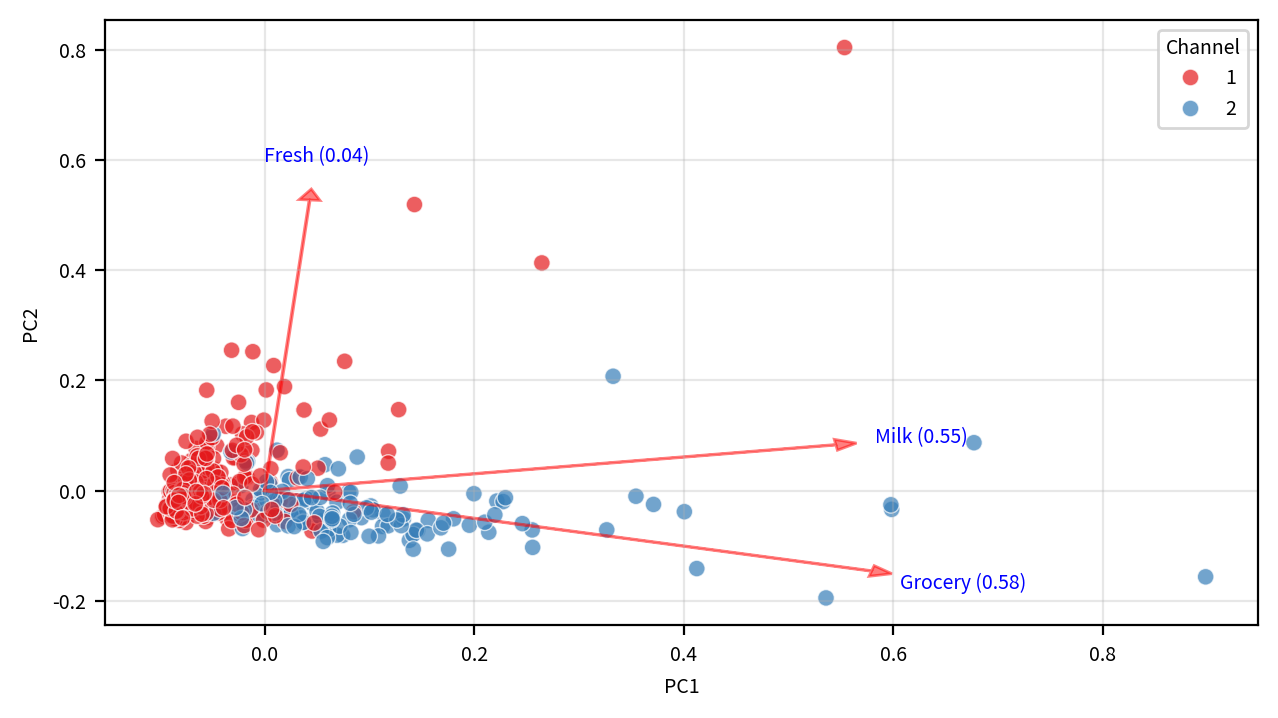

In [28]:
xname = "PC1"
yname = "PC2"

# 필요한 정보 추출
score = estimator.transform(sdf)
components = estimator.components_

x_index = pca_df.columns.get_loc(xname)
y_index = pca_df.columns.get_loc(yname)

xs = score[:, x_index]
ys = score[:, y_index]
n = score.shape[1]

scalex = 1.0 / (xs.max() - xs.min())
scaley = 1.0 / (ys.max() - ys.min())

# 시각화
figsize = (1280 / my_dpi, 720 / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.scatterplot(
    x=xs * scalex,
    y=ys * scaley,
    hue=origin["Channel"],  # ✅ pca_df["target"] 대신 (또는 origin["Region"])
    palette="Set1",
    ax=ax,
    alpha=0.7,
)

for i in range(n):
    ax.arrow(
        0,
        0,
        components[x_index, i],
        components[y_index, i],
        color="r",
        alpha=0.5,
        head_width=0.02,
        head_length=0.02,
    )

    ax.text(
        components[x_index, i] * 1.15,
        components[y_index, i] * 1.15,
        f"{df1.columns[i]} ({components[x_index, i]:.2f})",
        color="b",
        ha="center",
        va="center",
    )

ax.grid(True, alpha=0.3)
# ax.set_xlim(-1, 1)
# ax.set_ylim(-1, 1)
ax.set_xlabel(xname)
ax.set_ylabel(yname)

plt.tight_layout()
plt.show()
plt.close()